In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import numpy as np


In [2]:
# 设置字体为 SimHei（黑体），或者其他支持中文的字体
plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置字体
plt.rcParams['axes.unicode_minus'] = False  # 正常显示负号

In [3]:
# 获取当前文件所在目录的父目录
import os
import sys

current_dir = os.getcwd()
parent_dir = os.path.dirname(current_dir)

if parent_dir not in sys.path:
    sys.path.append(parent_dir)


from Dtool import fill_missing_values, plot_factors_by_pattern, plot_comparison_multiple, reverse_column, plot_feature_importance,plot_predictions


In [4]:
sheet = pd.read_excel('data_input/苯乙烯-纯苯价差.xlsx', sheet_name='Sheet1').rename(columns={'DataTime': 'Date'})
sheet = sheet.set_index('Date')
last_day = sheet['苯乙烯-纯苯价差'].last_valid_index()

future_data_30days = sheet[sheet.index > last_day]
target_days = pd.date_range(start=last_day+ pd.DateOffset(1), periods=21, freq='B')
target_end = target_days[-1]
new_index = pd.date_range(start=last_day+ pd.DateOffset(1), end=target_end, freq='B')
sheet = sheet.reindex(sheet.index.union(new_index))
sheet = sheet[sheet.index <= target_end]

sheet.tail()

,苯乙烯-纯苯价差,华东纯苯价格-EB期货指数
2025-12-02,NaN,NaN
2025-12-03,NaN,NaN
2025-12-04,NaN,NaN
2025-12-05,NaN,NaN
2025-12-08,NaN,NaN


In [5]:
sheet1 = pd.ExcelFile('eta/华东纯苯价格-EB期货指数_合并数据.xlsx').parse('Sheet1')
sheet1['Date'] = pd.to_datetime(sheet1['Date'], errors='coerce')
sheet1 = sheet1.sort_values('Date', ascending=True)
sheet1 = sheet1.drop(columns=['华东纯苯价格-EB期货指数'])
sheet1 = sheet1.dropna()
sheet1.head()

,Date,华东纯苯价格-EB期货指数_预测
16,2025-11-10,-1191.654057
15,2025-11-11,-1190.766347
14,2025-11-12,-1231.921317
13,2025-11-13,-1287.498966
12,2025-11-14,-1225.398125


In [6]:

# 合并 sheet1 和 sheet2 的数据到 sheet
sheet_daily = sheet.copy()
sheet_daily.index.name = 'Date'
sheet_daily = sheet_daily.reset_index()

# 合并 sheet1 的美国10年通胀预期数据
sheet_daily = pd.merge(
    sheet_daily,
    sheet1[['Date', '华东纯苯价格-EB期货指数_预测']],
    on='Date',
    how='left'
)
sheet_daily['华东纯苯价格-EB期货指数'] = sheet_daily['华东纯苯价格-EB期货指数'].fillna(sheet_daily['华东纯苯价格-EB期货指数_预测'])
sheet_daily = sheet_daily.drop(columns=['华东纯苯价格-EB期货指数_预测'])



sheet_daily = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2023-06-01')]
sheet_daily.tail(10)

,Date,苯乙烯-纯苯价差,华东纯苯价格-EB期货指数
2875,2025-11-25,NaN,-1331.582488
2876,2025-11-26,NaN,-1268.799357
2877,2025-11-27,NaN,-1185.969347
2878,2025-11-28,NaN,-1162.744525
2879,2025-12-01,NaN,-1182.240144
2880,2025-12-02,NaN,-1121.960443
2881,2025-12-03,NaN,NaN
2882,2025-12-04,NaN,NaN
2883,2025-12-05,NaN,NaN
2884,2025-12-08,NaN,NaN


In [7]:
last_day = sheet_daily['Date'][sheet_daily['苯乙烯-纯苯价差'].last_valid_index()]
last_day

Timestamp('2025-11-07 00:00:00')

In [8]:
sheet_daily = sheet_daily[
    (sheet_daily['Date'] > last_day) | 
    (sheet_daily['苯乙烯-纯苯价差'].notna())
]
# 删除两列都为空的行
sheet_daily = sheet_daily.dropna(subset=['苯乙烯-纯苯价差', '华东纯苯价格-EB期货指数'], how='all')
# 对华东纯苯价格-EB期货指数进行线性插值填充
sheet_daily['华东纯苯价格-EB期货指数'] = sheet_daily['华东纯苯价格-EB期货指数'].interpolate(method='linear')

################################# 划分 数据 训练 测试 预测 #################################
# 划分训练集、测试集和未来数据、设置测试集长度
train_data = sheet_daily[sheet_daily['Date'] <= last_day].copy()
test_period = 10
test_data = train_data[-test_period:].copy() 
train_data = train_data[:-test_period].copy()
future_data = sheet_daily[sheet_daily['Date'] > last_day].copy()

feature_columns = [
        '华东纯苯价格-EB期货指数'
]

predict_column = '苯乙烯-纯苯价差'

X_train = train_data[feature_columns]
y_train = train_data[predict_column]

X_test = test_data[feature_columns]
y_test = test_data[predict_column]

X_future = future_data[feature_columns]



# 训练线性回归模型
from sklearn.linear_model import LinearRegression
model = LinearRegression()
model.fit(X_train, y_train)

# 在测试集上进行预测
y_test_pred = model.predict(X_test)

# 在未来数据上进行预测
y_future_pred = model.predict(X_future)

# 将预测结果添加到原始数据中
sheet_daily.loc[test_data.index, '苯乙烯-纯苯价差_预测'] = y_test_pred
sheet_daily.loc[future_data.index, '苯乙烯-纯苯价差_预测'] = y_future_pred

# 打印模型评估指标
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np

test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
test_r2 = r2_score(y_test, y_test_pred)

print(f'测试集 RMSE: {test_rmse:.2f}')
print(f'测试集 R2: {test_r2:.2f}')


测试集 RMSE: 198.71
测试集 R2: -25.55


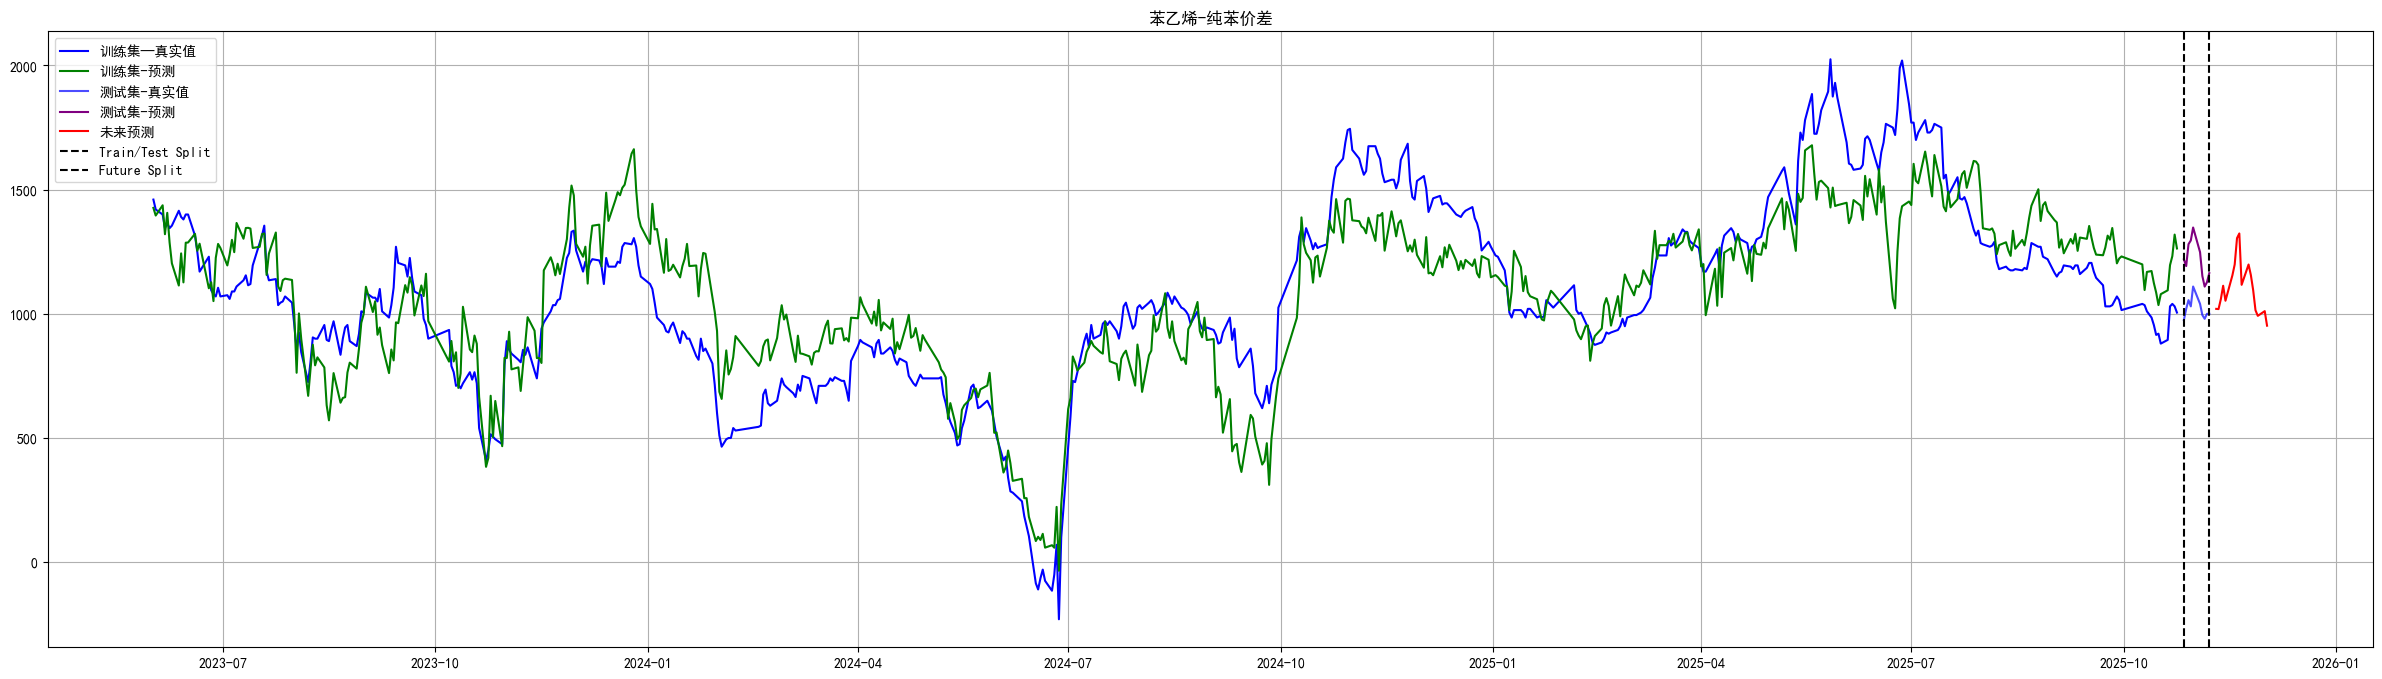

In [9]:
plt.figure(figsize=(30, 8))

# 绘制主要数据
plt.plot(train_data['Date'], y_train, label='训练集—真实值', color='blue')
plt.plot(train_data['Date'], model.predict(X_train), label='训练集-预测', color='green')
plt.plot(test_data['Date'], y_test, label='测试集-真实值', color='blue', alpha=0.7)
plt.plot(test_data['Date'], y_test_pred, label='测试集-预测', color='purple')
plt.plot(future_data['Date'], y_future_pred, label='未来预测', color='red')

# 添加分割线
plt.axvline(x=test_data['Date'].iloc[0], color='black', linestyle='--', label='Train/Test Split')
plt.axvline(x=last_day, color='black', linestyle='--', label='Future Split')

# 设置标题和图例
plt.title('苯乙烯-纯苯价差')
plt.legend()
plt.grid(True)
plt.show()


---

In [10]:
# 创建历史数据部分
historical = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '苯乙烯-纯苯价差']]
historical.columns = ['Date', '苯乙烯-纯苯价差']

# 创建预测数据部分 
forecast = sheet_daily[sheet_daily['Date'] > last_day][['Date', '苯乙烯-纯苯价差_预测']]
forecast.columns = ['Date', '苯乙烯-纯苯价差_预测']

# 获取最后一个有主焦煤价格/临汾值的行
last_price_row = historical.iloc[-1]
last_price_date = pd.to_datetime(last_price_row['Date'])
last_price = last_price_row['苯乙烯-纯苯价差']
# 创建新行,日期为最后一个有值日期的后一天
new_row = pd.DataFrame({
    'Date': [last_price_date + pd.Timedelta(days=1)],
    '苯乙烯-纯苯价差': [np.nan],
    '苯乙烯-纯苯价差_预测': [last_price]
})
# 将新行添加到forecast中
forecast = pd.concat([new_row, forecast])

# 合并历史和预测数据
merged_df_daily = pd.concat([historical, forecast], axis=0, join='outer')
merged_df_daily = merged_df_daily.sort_values('Date').reset_index(drop=True)
# 删除两列都为空的行
merged_df_daily = merged_df_daily.dropna(subset=['苯乙烯-纯苯价差', '苯乙烯-纯苯价差_预测'], how='all')
merged_df_daily = merged_df_daily.sort_values(by='Date', ascending=False)
merged_df_daily['Date'] = merged_df_daily['Date'].dt.strftime('%Y/%m/%d')
merged_df_daily.to_excel('eta/苯乙烯-纯苯价差_合并数据.xlsx', index=False,float_format='%.6f')   
merged_df_daily.head() 

,Date,苯乙烯-纯苯价差,苯乙烯-纯苯价差_预测
624,2025/12/02,NaN,952.233516
623,2025/12/01,NaN,1010.779798
622,2025/11/28,NaN,991.844800
621,2025/11/27,NaN,1014.401763
620,2025/11/26,NaN,1094.849890


In [11]:
# 创建历史数据部分
historical_monthly = sheet_daily[sheet_daily['Date'] <= last_day][['Date', '苯乙烯-纯苯价差']]
historical_monthly.columns = ['Date', '苯乙烯-纯苯价差']

# 创建预测数据部分 
forecast_monthly = sheet_daily[sheet_daily['Date'] >= pd.Timestamp('2024-10-01')][['Date', '苯乙烯-纯苯价差_预测']]
forecast_monthly.columns = ['Date', '苯乙烯-纯苯价差_预测']

merged_df_monthly = pd.merge(historical_monthly, forecast_monthly, on='Date', how='outer')
merged_df_monthly.set_index('Date', inplace=True)
merged_df_monthly = merged_df_monthly.resample('ME').mean()
merged_df_monthly.reset_index(inplace=True)
merged_df_monthly =merged_df_monthly.sort_values('Date', ascending=False)
merged_df_monthly['Date'] = merged_df_monthly['Date'].dt.strftime('%Y/%m/%d')
merged_df_monthly = merged_df_monthly.dropna(subset=['苯乙烯-纯苯价差', '苯乙烯-纯苯价差_预测'], how='all')
merged_df_monthly.to_excel('eta/苯乙烯-纯苯价差_月度数据.xlsx', index=False,float_format= '%.4f')
merged_df_monthly.head()

,Date,苯乙烯-纯苯价差,苯乙烯-纯苯价差_预测
30,2025/12/31,NaN,981.506657
29,2025/11/30,1003.000000,1130.948944
28,2025/10/31,996.111111,1266.962032
27,2025/09/30,1132.826087,NaN
26,2025/08/31,1222.380952,NaN


---

In [12]:
from Dcel import update_excel_data
# 使用示例
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "日度数据表"
identifier = "苯乙烯-纯苯价差"

# 调用函数更新数据
success = update_excel_data(merged_df_daily, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")

成功更新 日度数据表 中的数据
数据已成功更新到Excel文件


In [13]:
from Lcel import update_excel_data
file_path = "eta/1.汽柴煤油_数据上传.xlsx"
sheet_name = "详情页"
identifier = "苯乙烯-纯苯价差"       # NEW: 新增日期标识符列的抬头
# 调用函数更新数据
success = update_excel_data(merged_df_monthly, file_path, sheet_name, identifier)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")


数据过滤完成: 保留 24 条数据（2024/01/31 之后），按时间倒序排列


已完成：插入/更新数据，并重新计算'方向/偏差率' (protected_date = 2025/11/30, cutoff_date = 2024/01/31)
数据已成功更新到Excel文件


In [14]:
'''
from Ecel import generate_and_fill_excel
success = generate_and_fill_excel(
    daily_df =  merged_df_daily,
    target_name = 'LME铜价',        # 写入的"预测标的"显示名
    TARGET_COL = '预测值',
    output_path='update.xlsx'
)

if success:
    print("数据已成功更新到Excel文件")
else:
    print("数据更新失败，请检查错误信息")
'''

'\nfrom Ecel import generate_and_fill_excel\nsuccess = generate_and_fill_excel(\n    daily_df =  merged_df_daily,\n    target_name = \'LME铜价\',        # 写入的"预测标的"显示名\n    TARGET_COL = \'预测值\',\n    output_path=\'update.xlsx\'\n)\n\nif success:\n    print("数据已成功更新到Excel文件")\nelse:\n    print("数据更新失败，请检查错误信息")\n'